In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [2]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3', *params, i, 
            gate_round=gate_round, parametrize=True)
        
def two_qubit_layer(circ, gate2='CZ', reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)
    
    for i in regs:
        circ.apply_gate(
            gate2, i, i + 1, gate_round=gate_round)

def ansatz_circuit(n, depth, gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)
    
    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)
        
        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, reverse=r % 2 == 0)
        
    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)
    
    return circ

In [3]:
n = 6
depth = 9
gate2 = 'CZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
circ

<Circuit(n=6, n_gates=105, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

We can extract just the unitary part of the circuit as a tensor network like so:

In [4]:
V = circ.uni

You can see it already has various ``tags`` identifying its structure (indeed enough to uniquely identify each gate):

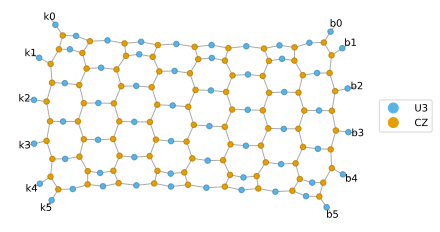

In [5]:
V.graph(color=['U3', gate2], show_inds=True)

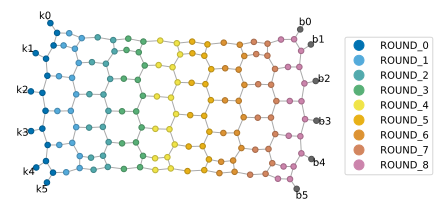

In [6]:
V.graph(color=[f'ROUND_{i}' for i in range(depth)], show_inds=True)

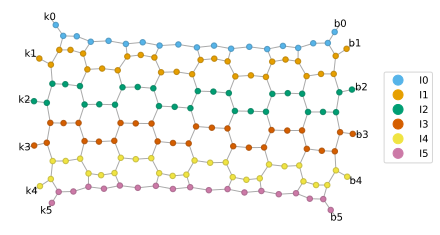

In [7]:
V.graph(color=[f'I{i}' for i in range(n)], show_inds=True)

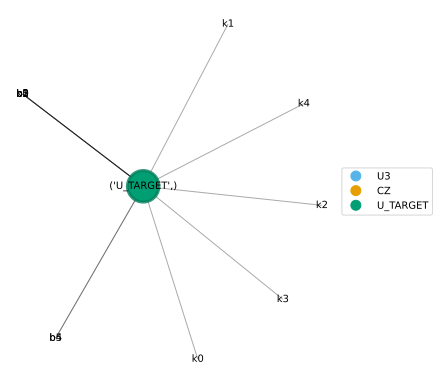

In [8]:
# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'k{i}' for i in range(n)] + [f'b{i}' for i in range(n)],
    tags={'U_TARGET'}
)
U.graph(color=['U3', gate2, 'U_TARGET'])

The core object describing how similar two unitaries are is: $\mathrm{Tr}(V^{\dagger}U)$, which we can naturally visualize at a tensor network:

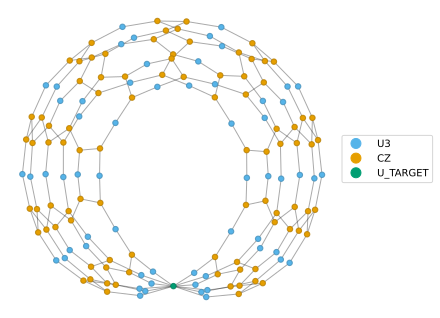

In [9]:
(V.H & U).graph(color=['U3', gate2, 'U_TARGET'])

For our loss function we'll normalize this and negate it (since the optimizer *minimizes*).

In [10]:
def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / 2**n

# check our current unitary 'infidelity':
loss(V, U)

0.9884572421982941

In [11]:
# use the autograd/jax based optimizer
import quimb.tensor.optimize as qto

tnopt = qto.TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    constant_tags=[gate2],    # within V we also want to keep all the CZ gates constant
    autograd_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

We could call ``optimize`` for pure gradient based optimization, but since unitary circuits can be tricky we'll use ``optimize_basinhopping`` which combines gradient descent with 'hopping' to escape local minima:

In [12]:
# allow 10 hops with 500 steps in each 'basin'
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

  0%|          | 0/5000 [00:00<?, ?it/s]/home/johnnie/conda/lib/python3.7/site-packages/jax/lax/lax.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  lambda t, new_dtype, old_dtype: [convert_element_type(t, old_dtype)])
0.005386710166931152 [best: 0.0053675174713134766] :  29%|██▊       | 1427/5000 [00:55<02:17, 25.92it/s] 


The optimized tensor network still contains ``PTensor`` instances but now with optimized parameters. 
For example, here's the tensor of the ``U3`` gate acting on qubit-2 in round-4:

In [13]:
V_opt['U3', 'I2', 'ROUND_4']

PTensor(shape=(2, 2), inds=('_e3ff6e00000b5', '_e3ff6e00000a3'), tags=('U3', 'GATE_46', 'ROUND_4', 'I2'))

We can see the parameters have been updated by the training:

In [14]:
# the initial values
V['U3', 'ROUND_4', 'I2'].params

array([0.23596186, 0.01767717, 0.67314318])

In [15]:
# the optimized values
V_opt['U3', 'ROUND_4', 'I2'].params

array([-8.14000795e-04,  8.62103916e-01, -2.02170731e-01])

We can see what gate these parameters would generate:

In [16]:
qu.U_gate(*V_opt['U3', 'ROUND_4', 'I2'].params)

[[ 9.999999e-01+0.000000e+00j  3.987110e-04-8.172418e-05j]
 [-2.648928e-04-3.090002e-04j  7.900331e-01+6.130640e-01j]]

A final sanity check we can perform is to try evolving a random state with the target unitary and trained circuit and check the fidelity between the resulting states.

First we turn the tensor network version of $V$ into a dense matrix:

In [17]:
V_opt_dense = V_opt.to_dense([f'k{i}' for i in range(n)], [f'b{i}' for i in range(n)])

Next we create a random initial state, and evolve it with the 

In [18]:
psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = V_opt_dense @ psi0

The (in)fidelity should broadly match our training loss:

In [19]:
f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 99.46 %'